#**Proyecto final, área de Astrofísica/Cosmología**

## Integrantes del equipo 

* Barrón Del Vecchyo Barrón Carlo Roberto
* Gamucero Juan Pablo
* López Granados Iván
* Soberanes Soberanes Hilkar Val

#**Identificación de Pulsares**

# Introducción a pulsares

Los pulsares fueron descubiertos en 1967 por Anthony Hewish y Jocelyn Bell en el observatorio de radio astronomía en Cambridge. 
Estos son estrellas de neutrones fuertemente magnetizadas. La rápida rotación  las hace poderosos generadores eléctricos, capaces de acelerar las partículas cargadas hasta energías de mil millones de millones de voltios. Estas partículas cargadas son responsables del haz de radiación en radio, luz, rayos-X, y rayos gamma. Su energía proviene de la rotación de la estrella, el cual va disminuyendo su velocidad y esta disminución es detectada como alargamiento del período de los pulsos.

Los estudios indican que un púlsar es una estrella de neutrones pequeña que gira a gran velocidad. El más conocido está en la nebulosa de Cangrejo. 

<center>
<img src= https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Pulsar_schematic.svg/720px-Pulsar_schematic.svg.png>
<p>
<font size=2>
Diagrama esquemático de un púlsar que ilustra las líneas de campo magnético en blanco, el eje de rotación en verde y los dos chorros polares de radiación en azul.

# Criterio de clasificación

## El dataset HTRU-2

Fruto del Sondeo de Resolución Universal a Altos Tiempos (HTRU por sus siglas en inglés), se tomaron $17,898$ imágenes de fuentes lumínicas candidatas a ser tratadas como púlsares. Tras un mayor estudio de sus emisiones periódicas en el espectro de microondas se logró etiquetar a cada candidato, obteniendo un dataset altamente desequilibrado pues $16,259$ imágenes resultaron ser falsas alarmas dadas por ruido u otras fuentes de emisión en el infrarrojo lejano y $1,639$ imágenes son efectivamente púlsares.

El resultado original de este sondeo fue el dataset HTRU-1, conteniendo las imágenes brutas en formato RGB para cada candidato a púlsar, por ejemplo:



*   Púlsar: ![picture](https://raw.githubusercontent.com/as595/HTRU1/master/media/pulsar_0000.jpg)
*   Falsa alarma: ![picture](https://raw.githubusercontent.com/as595/HTRU1/master/media/cand_000003.jpg)


Sin embargo el tratamiento de $17,898$ imágenes de dimensiones $32 \times 32 \times 3$ resulta ser ineficiente, además que es difícil detectar un púlsar en un sólo instante de tiempo, pues la principal caractrerística de estas estrellas son los pulsos que envia en un intervalo de tiempo por lo que se decidió crear el dataset HTRU-2.

La idea detrás de este dataset es estudiar la intensidad de señal recibida en función del tiempo, del ángulo desde el que se observa medido desde el centro de la estrella y de la frecuencia utilizada (espectrometría). 

Con estas mediciones, se procede a:


1.   Generar ángulo contra intensidad para cada tiempo, y sumar todas estas gráficas para obtener una sola, llamada **Perfil integrado**
<center>
  <img src="https://allofyourbases.files.wordpress.com/2019/03/pulsestack-e1552071632736.gif">
  <p>
  <font size=2>
    Gráficas de Intensidad contra ángulo para cada tiempo (arriba) y perfil integrado (abajo). Imagen tomada de <a href="https://www.cv.nrao.edu/~sransom/web/Ch6.html">Essentials of Radio Astronomy </a>.

2.   Calcular el tiempo en el que se recibe el máximo de intensidad del pulso para cada frecuencia, llamado Dispersión, y graficarlo contra su incertidumbre asociada, esto genera una curva llamada **Medición de Dispersión - Ratio de Señal a Ruido (DM-SNR por sus siglas en inglés)**.

<center>
  <img src="https://allofyourbases.files.wordpress.com/2019/03/dm_snr.png">
  <p>
  <font size=2>
    Ejemplo de curva Medición de Dispersión - Ratio de Señal a Ruido. Imagen tomada de <a href="https://www.cv.nrao.edu/~sransom/web/Ch6.html">Essentials of Radio Astronomy </a>.



Finalmente, se caracterizan estas dos gráficas. Como se puede ver de los ejemplos, los perfiles en general parecen Gaussianos. Entonces para cada una de las gráficas se calcula:

<font color="red" size=4><p/>
  1.   Promedio <p/>
  2.   Desviación estándar<p/>
  3.   Kurtosis (dice qué tan "puntiaguda" es la gráfica)<p/>
  4.   Skewness (medida de asimetría)

Así, para cada candidato a pulsar se cuenta con 8 parámetros, correspondientes a los 4 parámetros anteriores para el perfil integrado y para el DM-SNR, y además nos permiten compararlo con una distribución normal estándar $e^{-x^2}$, que tiene promedio 0, desviación estándar 1, kutosis 3 y skewness 0

<center>
  <img src="http://sciences.usca.edu/biology/zelmer/305/norm/stanorm.jpg" width=400>
  <p>
  <font size=2>
    Distribución normal estándar. Imagen tomada de <a href="http://sciences.usca.edu/biology/zelmer/305/norm/">The Normal Distribution </a>.



Para más información sobre la recolección y clasificación de imágenes revisar el artículo original:



*   R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

Para más información sobre el dataset en general, revisar [esta liga](https://https://archive.ics.uci.edu/ml/datasets/HTRU2)


# Implementación del código

<font size=4>
    
Primero se importan todas las librerías necesarias 

In [ ]:
import numpy as np 
import pandas as pd 
from torchsummary import summary #Resumen de la arquitectura del modelo
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, TensorDataset
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from sklearn.metrics import confusion_matrix
%matplotlib inline

<font color='blue' size=4>    
#Clasifiación de señales para identificación de Pulsares

Se carga el conjunto de datos desde el link mostrado, haciendo uso del método pd.read_csv(). El parámetro de 'names' asigna nombre a las columnas.

In [ ]:
filename = "https://raw.githubusercontent.com/charitarthchugh/PulsarIdentification/master/HTRU_2.csv"
df = pd.read_csv(filename, names=["Mean of the integrated profile", "Standard deviation of the integrated profile", "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "target_class" ])

In [ ]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [ ]:
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


###Visualización de las muestras

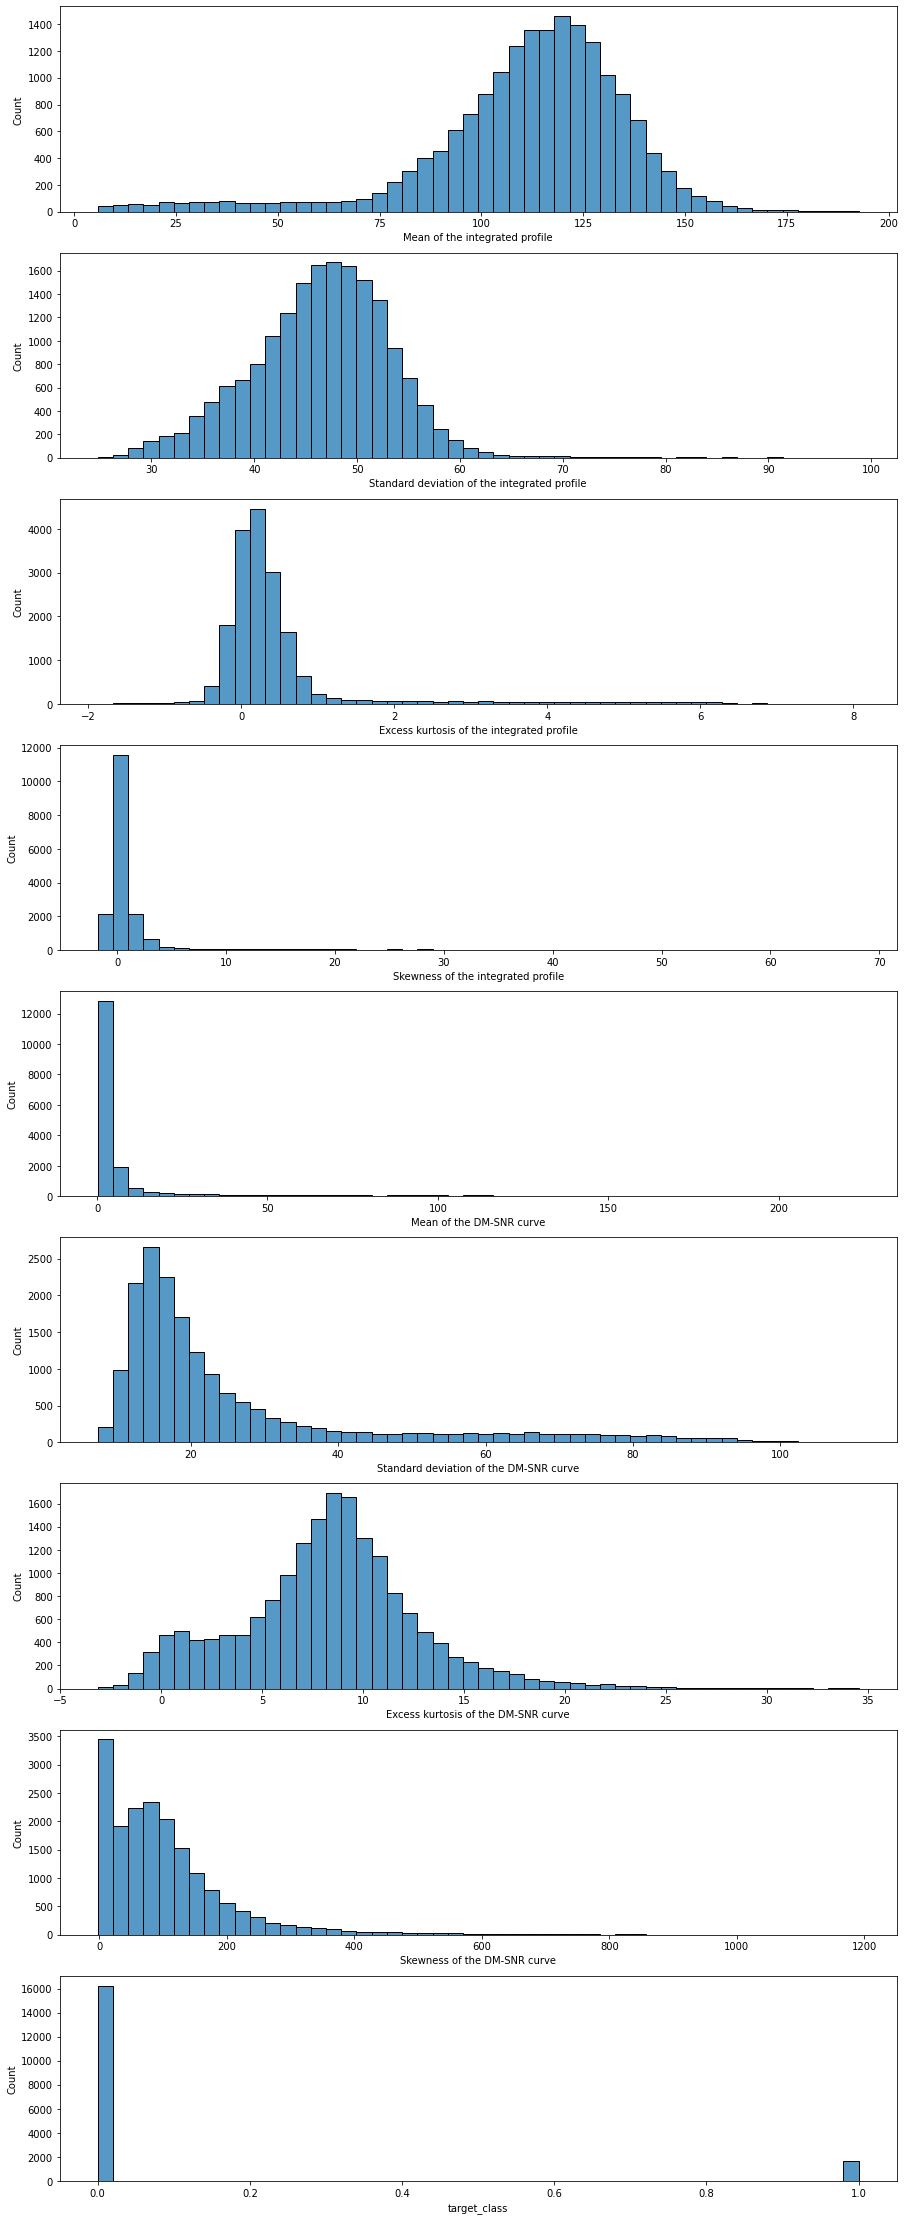

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=len(df.columns[:]),ncols=1,  figsize=(15, 40))
for i in range(len(df.columns[:])):
    feature = df.columns[i]
    plt.figure(figsize = (5, 5));
    data=df.copy()
    sns.histplot(x=data[feature].dropna(), ax=axes[i], bins=50)

Se observa la distribución de las muestras positivas y negativas

In [ ]:
count = len(df[df['target_class']==1])
print("Number of positive candidates: {}".format(count))
print("Number of negative candidates: {}".format(len(df)-count))

Number of positive candidates: 1639
Number of negative candidates: 16259


### Separación de targets y variables de entrada

In [ ]:
inputs_df = df.drop("target_class",axis=1) #Manera más facil de obtener las entradas - solo necesitamos la clase 
inputs_arr = inputs_df.to_numpy() 
targets_df = df["target_class"] #Manera más facil de obtener las salidas - solo neceistamos la clase
targets_arr = targets_df.to_numpy()

### Transformación de numpy array a tensores en Pytorch

In [ ]:
#output variables.
inputs=torch.from_numpy(inputs_arr).type(torch.float64)
targets=torch.from_numpy(targets_arr).type(torch.long)
inputs.shape, targets.shape

(torch.Size([17898, 8]), torch.Size([17898]))

In [ ]:
dataset=TensorDataset(inputs, targets)

### Separación en train_set, validation_set y test_set

In [ ]:
num_rows=df.shape[0]
val_percent = 0.1 #Porcentaje de validaicón
test_percent = 0.1 #Porcentaje de test
val_size = int(num_rows*val_percent)
test_size = int(num_rows*test_percent)
train_size = num_rows - val_size-test_size

In [ ]:
torch.manual_seed(2)#Nos aseguramos de que consigamos la misma validación cada vez.
train_ds, val_ds, test_ds = random_split(dataset, (train_size, val_size, test_size))
print("Muestras de entrenamiento: ",len(train_ds))
print("Muestras de validation:", len(val_ds))
print("Muestras test: ",len(test_ds))

Muestras de entrenamiento:  14320
Muestras de validation: 1789
Muestras test:  1789


In [ ]:
batch_size=256

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

### Configuración GPU/CPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# corroboramos el dispositivo
device=get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

##Visualización de la arquitectura

In [ ]:
import networkx as nx

class Network(object):
    
    def  __init__ (self,sizes):
        self.num_layers = len(sizes)
        print("It has", self.num_layers, "layers,")
        self.sizes = sizes
        print("with the following number of nodes per layer",self.sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, x_of_sample):
        """Return the output of the network F(x_of_sample) """        
        for b, w in zip(self.biases, self.weights):
            x_of_sample = sigmoid(np.dot(w, x_of_sample)+b)
        return x_of_sample
    
    def graph(self,sizes):
        a=[]
        ps={}
        Q = nx.Graph()
        for i in range(len(sizes)):
            Qi=nx.Graph()    
            n=sizes[i]
            nodos=np.arange(n)
            Qi.add_nodes_from(nodos)
            l_i=Qi.nodes
            Q = nx.union(Q, Qi, rename = (None, 'Q%i-'%i))
            if len(l_i)==1:
                ps['Q%i-0'%i]=[i/(len(sizes)), 1/2]
            else:
                for j in range(len(l_i)+1):
                    ps['Q%i-%i'%(i,j)]=[i/(len(sizes)),(1/(len(l_i)*len(l_i)))+(j/(len(l_i)))]
            a.insert(i,Qi)
        for i in range(len(a)-1):
            for j in range(len(a[i])):
                for k in range(len(a[i+1])):
                    Q.add_edge('Q%i-%i' %(i,j),'Q%i-%i' %(i+1,k))
        nx.draw(Q, pos = ps)

It has 4 layers,
with the following number of nodes per layer [8, 16, 16, 2]


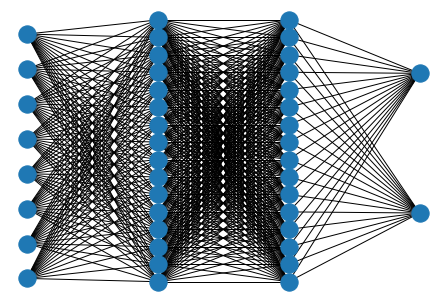

In [ ]:
layers = [inputs_df.shape[1], 16, 16, 2]
net = Network(layers)
net.graph(layers)

###Definición de la arquitectura en PyTorch

In [ ]:
class HTRU2Model(nn.Module):
    def __init__(self,):
        super(HTRU2Model,self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.float()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Gernera predicciones 
        loss = F.cross_entropy(out, targets) # Calcula la perdida
        return loss

    def predict_test(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Genera predicciones 
        return out
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Genera predicciones
        loss = F.cross_entropy(out, targets)   # Calcula la perdida
        acc = accuracy(out, targets)           # Calcula la presición
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina las perdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina las precisiones
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
model=to_device(HTRU2Model(),device)

In [ ]:
summary(model, (1,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             144
            Linear-2                [-1, 1, 16]             272
            Linear-3                 [-1, 1, 2]              34
           Softmax-4                 [-1, 1, 2]               0
Total params: 450
Trainable params: 450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Funciones auxiliares y de entrenamiento

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=optim.Adam):
  
    torch.cuda.empty_cache()
    history = []
    
    # Se establece el optimizador con la caida de la función de peso
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Se estbalece un ciclo de ritmos de aprendizaje 
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Fase de entrenamiento 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Se guarda y de actuliza el ritmo de entrenamiento
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Fase de validación
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

###Prueba para "arrancar" el modelo

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.6495359539985657, 'val_loss': 0.6277426481246948}]

### Hyperparámetros

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Entrenamiento

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00275, train_loss: 0.4597, val_loss: 0.3796, val_acc: 0.9295



Epoch [1], last_lr: 0.00757, train_loss: 0.3525, val_loss: 0.3404, val_acc: 0.9731



Epoch [2], last_lr: 0.01000, train_loss: 0.3411, val_loss: 0.3403, val_acc: 0.9720



Epoch [3], last_lr: 0.00950, train_loss: 0.3394, val_loss: 0.3400, val_acc: 0.9720



Epoch [4], last_lr: 0.00812, train_loss: 0.3393, val_loss: 0.3393, val_acc: 0.9726



Epoch [5], last_lr: 0.00611, train_loss: 0.3391, val_loss: 0.3384, val_acc: 0.9754



Epoch [6], last_lr: 0.00389, train_loss: 0.3387, val_loss: 0.3396, val_acc: 0.9726



Epoch [7], last_lr: 0.00188, train_loss: 0.3380, val_loss: 0.3387, val_acc: 0.9731



Epoch [8], last_lr: 0.00050, train_loss: 0.3381, val_loss: 0.3390, val_acc: 0.9737



Epoch [9], last_lr: 0.00000, train_loss: 0.3378, val_loss: 0.3389, val_acc: 0.9731
CPU times: user 3.06 s, sys: 974 ms, total: 4.03 s
Wall time: 6.67 s


### Precisión y pérdidas

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

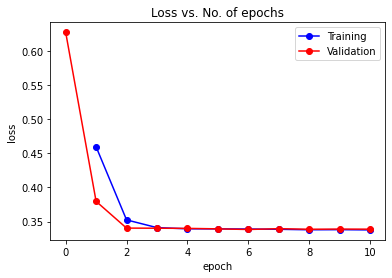

In [ ]:
plot_losses(history)

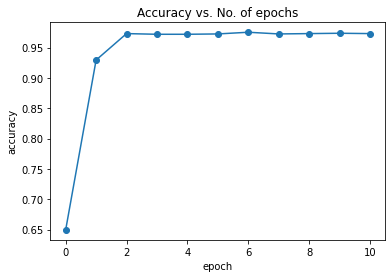

In [ ]:
plot_accuracies(history)

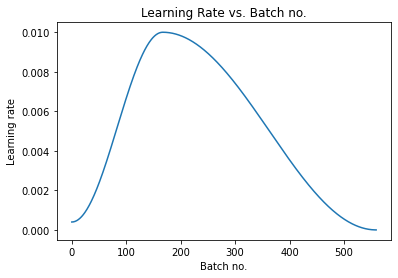

In [ ]:
plot_lrs(history)

##Evaluación del modelo y predicciones

In [ ]:
evaluate(model, test_dl)

{'val_acc': 0.9809738397598267, 'val_loss': 0.3316890299320221}

In [ ]:
test_targetsPredicted1 = []
#----------Evaluación con los parámetros aprendidos ------------------------
for batch in test_dl:
  test_targetsPredicted1.append((model.predict_test(batch)))
#----------Empaquetamiento de predicciones-----------------------------------
test_targetsPredicted2 = []
for i in range(len(test_targetsPredicted1)):
  for j in range(len(test_targetsPredicted1[i])):
    test_targetsPredicted2.append(round((((test_targetsPredicted1[i][j].detach()).numpy()))[1])) #Si el segundo elemento del array es alto, es un Pulsar
test_targetsPredicted2 = np.array(test_targetsPredicted2)

In [ ]:
test_targetReal = []
for i in range(len(test_ds)):
  test_targetReal.append(np.squeeze(test_ds[i][1].numpy()))
test_targetReal = np.array(test_targetReal)

In [ ]:
np.sum(test_targetsPredicted2)

154

In [ ]:
np.sum(test_targetReal)

172

In [ ]:
arr = confusion_matrix(test_targetReal, test_targetsPredicted2).T
arr

array([[1609,   26],
       [   8,  146]])

In [ ]:
arr = confusion_matrix(test_targetReal, test_targetsPredicted2, normalize = 'true').T
arr

array([[0.99505257, 0.15116279],
       [0.00494743, 0.84883721]])

In [ ]:
arr = 100*arr

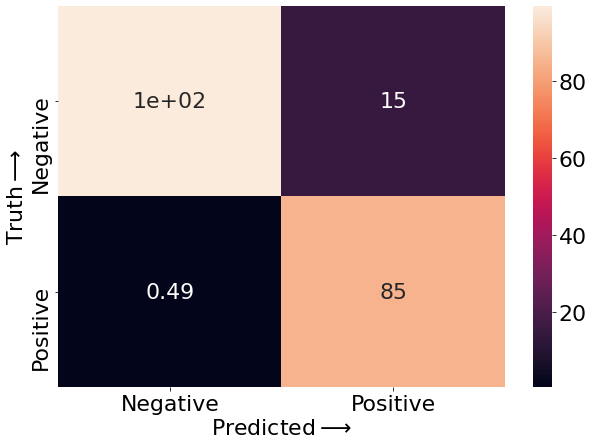

In [ ]:
df_cm = pd.DataFrame(arr, index = [i for i in ["Negative","Positive"]],
                  columns = [i for i in ["Negative","Positive"]])
plt.figure(figsize = (10,7))
plt.rcParams.update({'font.size': 22})
ax = sns.heatmap(df_cm, annot=True)
ax.set(xlabel=r'Predicted$\longrightarrow$', ylabel=r'Truth$\longrightarrow$');